In [1]:
# libraries used
import numpy as np
import pandas as pd
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

Then we split the training part into training set and validation set in order to set a custom cross validation method. 

The reason to do so is, it is only possible to use the previous data to predict the future, therefore, we split the data into 3 different times to train the different models. 
- dates before 2017 as the training set;
- dates from 2017-2018 as the validation set (in order to tune the hyperparameters of each single model that we will be using in the project); 
- and the dates after 2018 as the testing set (in order to compare the different metrics for each model that we have trained) 

In [5]:
train[train['time']=='2017-01-01 00:00:00'] # checking the first day of 2017 in order to split training from validation(INNER)

,time,norma_10_36.0_-5.0,norma_10_36.0_-5.5,norma_10_36.0_-6.0,norma_10_36.0_-6.5,norma_10_36.5_-5.0,norma_10_36.5_-5.5,norma_10_36.5_-6.0,norma_10_36.5_-6.5,norma_10_37.0_-5.0,...,v100_36.0_-6.5,v100_36.5_-5.0,v100_36.5_-5.5,v100_36.5_-6.0,v100_36.5_-6.5,v100_37.0_-5.0,v100_37.0_-5.5,v100_37.0_-6.0,v100_37.0_-6.5,response
5844,2017-01-01 00:00:00,7.452657,7.070566,7.775291,7.284788,5.246882,5.476711,5.884517,5.853224,1.756049,...,1.289933,1.92484,1.589894,1.661012,1.478627,1.195299,0.855764,0.314344,0.721556,1321.554


In [6]:
train.iloc[5844]

time                  2017-01-01 00:00:00
norma_10_36.0_-5.0                7.45266
norma_10_36.0_-5.5                7.07057
norma_10_36.0_-6.0                7.77529
norma_10_36.0_-6.5                7.28479
                             ...         
v100_37.0_-5.0                     1.1953
v100_37.0_-5.5                   0.855764
v100_37.0_-6.0                   0.314344
v100_37.0_-6.5                   0.721556
response                          1321.55
Name: 5844, Length: 98, dtype: object

In [7]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5844))                  # dates before 2017 to train
test_indices = list(range(5844, len(train)))         # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

### Defining different functions to ease the process

During the project, we will be using three most popular methods which are the as the followings: 
1. Random Forest
2. Gradient Boosting
3. Support Vector Machines

We define different functions in order to facilitate the process of training part, by using these functions, it is only necessary to give three arguments: 
1. Training set
2. Testing set 
3. The different values that we want to tune for the hyperparameters

In [8]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [9]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [10]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 


Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [11]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_all','GB_all','SVM_all','lm_all',
                                'RF_uv','GB_uv','SVM_uv', 'lm_uv',
                                'RF_module','GB_module','SVM_module','lm_module'])

In [12]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### 1. U,V COMPONENT + MODULE

We start training the models by using all the variables that we have got in the data set. 

#### 1.1 Random Forest

For random forest, we tune 4 different hyperparameters: 
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 7)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 12)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[130, 280)$;
- and max_features which is the maximum number of features considered for splitting a node, we tune it randomly in range $[25, 38)$

In [13]:
start_rf = time.time()

params_rf = {'max_depth': sp_randint(4, 7), 'min_samples_leaf': sp_randint(4, 12),
             'n_estimators': sp_randint(130, 280), 'max_features': sp_randint(25, 38)}
rf1 = optimize_rf(x_train, y_train, params_rf)

end_rf = time.time()
time_rf = end_rf - start_rf

In [14]:
time_rf

423.37404799461365

The best hyperparameters for the random forest model are as follows:


In [15]:
rf1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=26, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=181, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [16]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [17]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_all')

explained variance of training set: 0.940074475147976
explained variance of testing set: 0.8986717376127514
maximum error of training set: 1553.817669704219
maximum error of testing set: 1632.7890170213411
mae of training set: 177.59902905287836
mae of testing set: 201.79169293587117
mse of training set: 60857.91424615185
mse of testing set: 85597.33352829702
rmse of training set: 246.6939688078163
rmse of testing set: 292.57021982474055


Training by random forest using all the variables, we got the following conclusions:
- The model is acceptable, we have the explained variance of testing set of almost **90%**; the rooted mean square error is **292**
- The difference between the results of training set and testing set is not that much, which means that there is no overfitting and underfitting in the model

#### 1.2 Gradient Boosting

For gradient boosting, we tune 4 different hyperparameters: 

- learning_rate determines the weight of each tree added to the global model, we tune it randomly in range $(0.0001, 0.6)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[180, 300)$;
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 8)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 10)$;

In [18]:
start_gb = time.time()

params_gb = {'learning_rate': loguniform(0.0001, 0.6), 'n_estimators':sp_randint(180, 300),
             'max_depth':sp_randint(4, 8), 'min_samples_leaf':sp_randint(4, 10)}
gb1 = optimize_gb(x_train, y_train, params_gb)

end_gb = time.time()
time_gb = end_gb - start_gb

In [19]:
time_gb

2978.6254930496216

The best hyperparameters for the random forest model are as follows:

- learning_rate=0.045313495689355436,
- max_depth=6,
- min_samples_leaf=5,
- n_estimators=216

In [20]:
gb1

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.04517946284620146,
                          loss='ls', max_depth=6, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=263, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [21]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

Training by gradient boosting using all the variables, we can get the following conclusions: 
- The model has the explained variance of 90.9%, and the rmse of 276, comparing the results to rf, gb works a slightly better
- But the difference of the results for training set and testing set is also higher, there might be the overfitting problem

In [22]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_all')

explained variance of training set: 0.9813939316895087
explained variance of testing set: 0.9094402731156184
maximum error of training set: 741.2644206660761
maximum error of testing set: 1612.5228443050598
mae of training set: 100.90135657641582
mae of testing set: 181.90980870946296
mse of training set: 18895.482475801287
mse of testing set: 76499.16859903837
rmse of training set: 137.46083979010635
rmse of testing set: 276.5848307464427


#### 1.3 Support Vector Machine

For support vector machine method, we tune 3 different hyperparameters: 

- kernel, it is a function used so that the data points become linearly separable, it is set to be rbf.
- C, C parameter adds a penalty for each misclassified data point.
- gamma, gamma parameter of RBF controls the distance of influence of a single training point

In [23]:
start_svm = time.time()

params_svm = {'C': loguniform(10e-3, 10e+3),
              'gamma': loguniform(10e-6, 10e+1),
              'kernel': ['rbf']}
svm1 = optimize_svm(x_train, y_train, params_svm)

end_svm = time.time()
time_svm = end_svm - start_svm

In [24]:
time_svm

402.24669790267944

The best hyperparameters for SVM model are as follows:

In [25]:
svm1

SVR(C=4346.978377124008, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=4.1899453476225605e-05, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [27]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_all')

explained variance of training set: 0.9652514614544221
explained variance of testing set: 0.8046896195561957
maximum error of training set: 1724.3942274843612
maximum error of testing set: 1863.03247084103
mae of training set: 91.85684740339548
mae of testing set: 272.6641722162593
mse of training set: 35408.90026638805
mse of testing set: 165778.80723418
rmse of training set: 188.17252792686836
rmse of testing set: 407.15943711791823


Training by support vector machine using all the variables, we can find out that it did not work pretty well due to the fact that it needs more computer cost in order to get more precission. Due to the condition that we have, we will just leave it like that. 

### 2. ONLY U, V COMPONENT

Secondly, we will train the model removing the module variables, which are 24 of them (12 coordinates for uv10 and uv100).

In [28]:
# create a new data set that does not contain the module variable
data_u_v = data[data.columns.drop(list(data.filter(regex='norma')))]

In [29]:
# checking the shape is correct
# 98-24=74, we had 98 variables before (INCLUDING TIME AND RESPONSE), 
# we have 24 variables of module (12 coordinates for uv10 and 12 coordinates for uv100)
data_u_v.shape 

(11682, 74)

In [30]:
# splitting the data set into training set and testing set 
train_uv = data_u_v[data_u_v['time']<'2018-01-01 00:00:00']
test_uv = data_u_v[data_u_v['time']>='2018-01-01 00:00:00']

y_train_uv = train_uv['response'].values
x_train_uv = train_uv[[x for x in train_uv.columns if (x != 'response') & (x != 'time')]].values

y_test_uv = test_uv['response'].values
x_test_uv = test_uv[[x for x in test_uv.columns if (x != 'response') & (x != 'time')]].values

#### 2.1 Random Forest

In [31]:
params_rf2 = {'max_depth': sp_randint(4, 8), 'min_samples_leaf': sp_randint(5, 12),
              'n_estimators': sp_randint(130, 260), 'max_features': sp_randint(18, 32)}

rf2 = optimize_rf(x_train_uv, y_train_uv, params_rf2)

In [32]:
rf2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=212, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [33]:
rf2_pred_train = rf2.predict(x_train_uv)
rf2_pred_test = rf2.predict(x_test_uv)

Training by random forest removing module variables, we got the following conclusions:
- It has the explained variance of 88% and rmse of 314. Comparing the model to the model that is trained with all the variables, the results has worsened, it is preferred to use all the variables instead of removing the modules.  

In [34]:
metrics(y_train_uv, rf2_pred_train, y_test_uv, rf2_pred_test, 'RF_uv')

explained variance of training set: 0.9379780448034505
explained variance of testing set: 0.8826835692042009
maximum error of training set: 1501.0950675665708
maximum error of testing set: 1655.2492867343576
mae of training set: 188.5378092189198
mae of testing set: 226.12712608385843
mse of training set: 62987.253683937255
mse of testing set: 99100.2258210128
rmse of training set: 250.9726154064169
rmse of testing set: 314.80188344578374


#### 2.2 Gradient Boosting

In [35]:
params_gb2 = {'learning_rate': loguniform(0.0001, 0.6), 'n_estimators':sp_randint(170, 320),
              'max_depth':sp_randint(4,8), 'min_samples_leaf':sp_randint(5, 15)}

gb2 = optimize_gb(x_train_uv, y_train_uv, params_gb2)

In [36]:
gb2

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.023534553741953738,
                          loss='ls', max_depth=7, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=6,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=238, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [37]:
gb2_pred_train = gb2.predict(x_train_uv)
gb2_pred_test = gb2.predict(x_test_uv)

Training by gradient boosting removing module variables, we got the following conclusions:
- It has the explained variance of 90% and rmse of 283. Comparing the model to the model that is trained with all the variables, the results are slightly worse. Although that, it works better than random forest using the same variables. 

In [38]:
metrics(y_train_uv, gb2_pred_train, y_test_uv, gb2_pred_test, 'GB_uv')

explained variance of training set: 0.9809675957162988
explained variance of testing set: 0.904951819017044
maximum error of training set: 879.070811333944
maximum error of testing set: 1668.2480948353211
mae of training set: 103.19078757970622
mae of testing set: 188.97722874483367
mse of training set: 19328.45003112561
mse of testing set: 80302.07871474787
rmse of training set: 139.02679609027035
rmse of testing set: 283.37621409488105


#### 2.3Support Vector Machines

In [39]:
params_svm2 = {'C': loguniform(10e-3, 10e+3),
               'gamma': loguniform(10e-6, 10e+1),
               'kernel': ['rbf']}

svm2 = optimize_svm(x_train_uv, y_train_uv, params_svm2)

In [40]:
svm2

SVR(C=6520.455304800639, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=1.6649844562343352e-05, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
svm2_pred_train = svm2.predict(x_train_uv)
svm2_pred_test = svm2.predict(x_test_uv)

In [42]:
metrics(y_train_uv, svm2_pred_train, y_test_uv, svm2_pred_test, 'SVM_uv')

explained variance of training set: 0.9349396132972482
explained variance of testing set: 0.823074521027504
maximum error of training set: 1972.6033739988957
maximum error of testing set: 2551.6427391188454
mae of training set: 154.29767465385802
mae of testing set: 261.7184982097614
mse of training set: 66417.63614738059
mse of testing set: 150071.07629106726
rmse of training set: 257.7161930251582
rmse of testing set: 387.3900828506936


### 3. ONLY MODULE

Finally, we train the models using only the modules instead of u,v components. Now we will only have 48 variables (48 variables of u,v components: 12 coordinates for u,v 10 and 100).

In [43]:
# creating data set that does not contain u,v components
data_module = data[data.columns.drop(list(data.filter(regex='u100')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v100')))]

data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='u10')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v10')))]

In [44]:
# splitting the data set into training set and testing set 
train_module = data_module[data_module['time']<'2018-01-01 00:00:00']
test_module = data_module[data_module['time']>='2018-01-01 00:00:00']


y_train_module = train_module['response'].values
x_train_module = train_module[[x for x in train_module.columns if (x != 'response') & (x != 'time')]].values

y_test_module = test_module['response'].values
x_test_module = test_module[[x for x in test_module.columns if (x != 'response') & (x != 'time')]].values

In [45]:
# INCLUDING TIME AND RESPONSE
data_module.shape

(11682, 50)

#### 3.1 Random Forest

In [46]:
params_rf3 = {'max_depth': sp_randint(4, 9), 'min_samples_leaf': sp_randint(5, 20),
              'n_estimators': sp_randint(180, 300), 'max_features': sp_randint(13, 25)}

rf3 = optimize_rf(x_train_module, y_train_module, params_rf3)

In [47]:
rf3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=258, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [48]:
rf3_pred_train = rf3.predict(x_train_module)
rf3_pred_test = rf3.predict(x_test_module)

In [49]:
metrics(y_train_module, rf3_pred_train, y_test_module, rf3_pred_test, 'RF_module')

explained variance of training set: 0.9322362008385995
explained variance of testing set: 0.8668600296269332
maximum error of training set: 1677.645166529765
maximum error of testing set: 1894.4831951999058
mae of training set: 188.12884027900046
mae of testing set: 229.06900313010246
mse of training set: 68818.0739108225
mse of testing set: 112630.0973195099
rmse of training set: 262.3319917791623
rmse of testing set: 335.60407822240467


#### 3.2 Gradient Boosting

In [50]:
params_gb3 = {'learning_rate': loguniform(0.0001, 0.6), 'n_estimators':sp_randint(170, 330),
              'max_depth':sp_randint(4, 9), 'min_samples_leaf':sp_randint(6, 20)}

gb3 = optimize_gb(x_train_module, y_train_module, params_gb3)

In [51]:
gb3

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0352631446430476,
                          loss='ls', max_depth=6, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=11,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=323, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [52]:
gb3_pred_train = gb3.predict(x_train_module)
gb3_pred_test = gb3.predict(x_test_module)

In [53]:
metrics(y_train_module, gb3_pred_train, y_test_module, gb3_pred_test, 'GB_module')

explained variance of training set: 0.9695467549651713
explained variance of testing set: 0.8840583563072948
maximum error of training set: 1085.0708255679892
maximum error of testing set: 1921.210124365763
mae of training set: 125.95808309146398
mae of testing set: 209.67538410873937
mse of training set: 30926.93997916929
mse of testing set: 98093.32330317
rmse of training set: 175.860569711261
rmse of testing set: 313.1985365597515


#### 3.3 Support Vector Machine

In [54]:
params_svm3 = {'C': loguniform(10e-3, 10e+3),
              'gamma': loguniform(10e-6, 10e+1),
              'kernel': ['rbf']}

svm3 = optimize_svm(x_train_module, y_train_module, params_svm3)

In [55]:
svm3

SVR(C=2208.01988715696, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=3.254116391593082e-05, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [56]:
svm3_pred_train = svm3.predict(x_train_module)
svm3_pred_test = svm3.predict(x_test_module)

In [57]:
metrics(y_train_module, svm3_pred_train, y_test_module, svm3_pred_test, 'SVM_module')

explained variance of training set: 0.9310189039282755
explained variance of testing set: 0.801718205035445
maximum error of training set: 1948.6132107815495
maximum error of testing set: 2077.0492789420787
mae of training set: 151.7741941048242
mae of testing set: 278.1460720713256
mse of training set: 70528.45414422163
mse of testing set: 168648.0355078337
rmse of training set: 265.571937795057
rmse of testing set: 410.66779214814704


### Baseline models

##### All the variables

In [58]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [60]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm_all')

explained variance of training set: 0.8928384674819424
explained variance of testing set: 0.8734890779408248
maximum error of training set: 3241.2158673961335
maximum error of testing set: 1970.5855314610258
mae of training set: 238.82514927809743
mae of testing set: 238.44483446929038
mse of training set: 108828.41156899405
mse of testing set: 106899.29747014951
rmse of training set: 329.89151484843325
rmse of testing set: 326.95458013331074


##### u,v 

In [61]:
lm2 = linear_model.LinearRegression()
lm2.fit(x_train_uv, y_train_uv)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
lm2_pred_train = lm2.predict(x_train_uv)
lm2_pred_test = lm2.predict(x_test_uv)

In [63]:
metrics(y_train_uv, lm2_pred_train, y_test_uv, lm2_pred_test, 'lm_uv')

explained variance of training set: 0.7729500256780586
explained variance of testing set: 0.657990599694855
maximum error of training set: 3353.88968098611
maximum error of testing set: 2948.692811328778
mae of training set: 358.9170759108931
mae of testing set: 388.48910434673434
mse of training set: 230581.69729024748
mse of testing set: 289052.1298655628
rmse of training set: 480.1892307104018
rmse of testing set: 537.6356850745333


##### only module

In [64]:
lm3 = linear_model.LinearRegression()
lm3.fit(x_train_module, y_train_module)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
lm3_pred_train = lm3.predict(x_train_module)
lm3_pred_test = lm3.predict(x_test_module)

In [66]:
metrics(y_train_module, lm3_pred_train, y_test_module, lm3_pred_test, 'lm_module')

explained variance of training set: 0.8688718572122898
explained variance of testing set: 0.8520478304146388
maximum error of training set: 3792.32146434088
maximum error of testing set: 2252.6971911070245
mae of training set: 267.90682757074813
mae of testing set: 270.96236287024766
mse of training set: 133167.81830433477
mse of testing set: 125252.6934451557
rmse of training set: 364.92166050309316
rmse of testing set: 353.9105726665363


In [67]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_all,0.940074,0.898672,1553.82,1632.79,177.599,201.792,60857.9,85597.3,246.694,292.57
GB_all,0.981394,0.90944,741.264,1612.52,100.901,181.91,18895.5,76499.2,137.461,276.585
SVM_all,0.965251,0.80469,1724.39,1863.03,91.8568,272.664,35408.9,165779,188.173,407.159
lm_all,0.892838,0.873489,3241.22,1970.59,238.825,238.445,108828,106899,329.892,326.955
RF_uv,0.937978,0.882684,1501.1,1655.25,188.538,226.127,62987.3,99100.2,250.973,314.802
GB_uv,0.980968,0.904952,879.071,1668.25,103.191,188.977,19328.5,80302.1,139.027,283.376
SVM_uv,0.93494,0.823075,1972.6,2551.64,154.298,261.718,66417.6,150071,257.716,387.39
lm_uv,0.77295,0.657991,3353.89,2948.69,358.917,388.489,230582,289052,480.189,537.636
RF_module,0.932236,0.86686,1677.65,1894.48,188.129,229.069,68818.1,112630,262.332,335.604
GB_module,0.969547,0.884058,1085.07,1921.21,125.958,209.675,30926.9,98093.3,175.861,313.199


In [68]:
time_running = pd.DataFrame(columns=['time_to_run'], 
                         index=['RF_all','GB_all','SVM_all'])

In [69]:
time_running.loc['RF_all','time_to_run']=time_rf
time_running.loc['GB_all','time_to_run']=time_gb
time_running.loc['SVM_all','time_to_run']=time_svm

Observing this table which contains the time spent runing using all the variables, we can see that gradient boosting method has taken the longest time to finish runing, but also it worked the best.

In [70]:
time_running

,time_to_run
RF_all,423.374
GB_all,2978.63
SVM_all,402.247


################################################

## Feature Importance

################################################

In [71]:
# Libraries used
# permutation test
import eli5
from eli5.sklearn import PermutationImportance

# Partial Dependence test
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Shap values
import shap

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [72]:
data = pd.read_csv('ensembleMean_merged.csv')

train = data[data['time']<'2018-01-01 00:00:00']
test = data[data['time']>='2018-01-01 00:00:00']

y_train = train['response']
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]]

y_test = test['response']
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]]

In [74]:
gb1 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.04517946284620146,
                          loss='ls', max_depth=6, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=263, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
gb11 = gb1.fit(x_train, y_train)
gb1_pred_train = gb11.predict(x_train)
gb1_pred_test = gb11.predict(x_test)

In [75]:
rf1 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=26, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=181, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)
rf11 = rf1.fit(x_train, y_train)
rf1_pred_train = rf11.predict(x_train)
rf1_pred_test = rf11.predict(x_test)

### Permutation Importance

##### 1. permutation test for the best model (gradient boosting with all variables)

The conclusions that we can get from the permutation test is that, as we have the first number in each row that shows how much the model performance decreased with a random shuffling with the metric 'accuracy', the most important variables for this data set according to method gradient boosting is the module of coordinate 36, -6 which means that the speed of that coordinate matters a lot (with value of 0.1922); after that the u component of coordinate 36, -5. 

Another important conlusion is that, we can see, the most important 5 features are all from the coordinates 36-36.5, 5-6

In [76]:
perm = PermutationImportance(gb11, random_state=10).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2354 ± 0.0084,norma_100_36.0_-6.0
0.0960 ± 0.0077,u100_36.0_-5.0
0.0245 ± 0.0015,norma_10_36.5_-6.0
0.0171 ± 0.0017,v100_36.5_-5.5
0.0117 ± 0.0021,u10_36.5_-6.0
0.0063 ± 0.0006,norma_100_36.0_-5.5
0.0063 ± 0.0014,norma_100_36.5_-6.0
0.0060 ± 0.0007,norma_10_36.0_-6.0
0.0048 ± 0.0016,v100_37.0_-6.5
0.0021 ± 0.0005,norma_10_37.0_-5.0


##### 2. permutation test for the 2nd best model (random forest with all variables)

In [77]:
perm2 = PermutationImportance(rf11, random_state=10).fit(x_test, y_test)
eli5.show_weights(perm2, feature_names = x_train.columns.tolist())

Weight,Feature
0.0673 ± 0.0035,norma_100_36.0_-6.0
0.0331 ± 0.0014,u100_36.0_-5.0
0.0265 ± 0.0032,norma_100_36.5_-6.0
0.0182 ± 0.0015,norma_10_36.5_-6.0
0.0128 ± 0.0018,norma_10_36.0_-6.0
0.0098 ± 0.0007,norma_100_36.0_-5.5
0.0075 ± 0.0010,u10_36.0_-5.0
0.0055 ± 0.0006,v100_36.5_-5.5
0.0043 ± 0.0010,u10_36.5_-6.0
0.0029 ± 0.0002,norma_10_36.5_-5.5


### Partial Dependence Plots

It shows by plot how will the predicted value change if we change a single variable in the data set.
The y axis is interpreted as change in the prediction from what it would be predicted at the baseline (the original prediction).
The blue shaded area show the area of confidence interval. 

In [78]:
feature_names = x_train.columns

For the feature module on coordinate (36.0, -6), as it increases, the energy production increases until a certain point around 12, faster speed beyond that appear to have less impact on predictions. The reason why when the wind speed gets very high, but the production does not grow as fast as before is due to the fact that, if the wind is very strong, the wind turbine stops by itself to avoid possible failures or breakdowns 

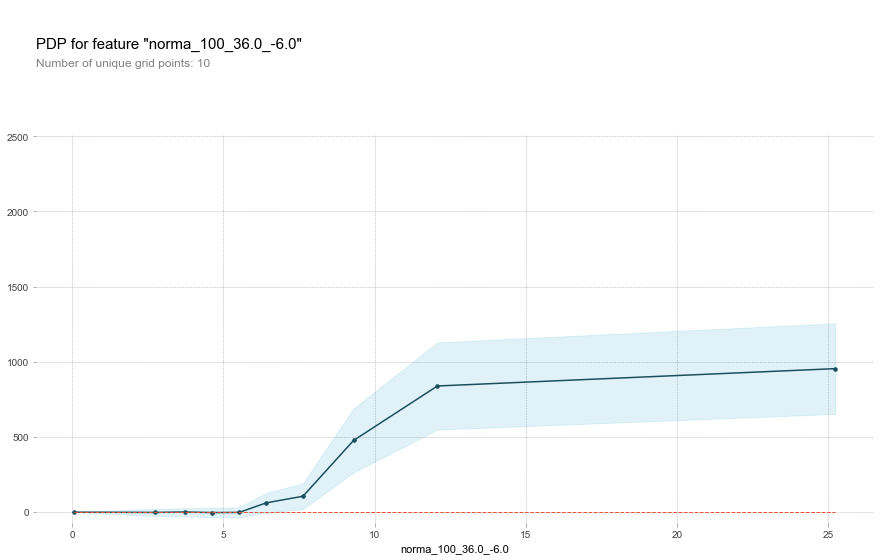

In [79]:
# 'norma_100_36.0_-6.0' most important variable according permutation test
# Create the data that we will plot
pdp_norma_100 = pdp.pdp_isolate(model=gb11, dataset=x_test, model_features=feature_names, feature='norma_100_36.0_-6.0')

# plot it
pdp.pdp_plot(pdp_norma_100, 'norma_100_36.0_-6.0')
plt.show()

From the following PDP plot of u component on coordinate (36.0, -5.0), we can observe that negative values of this variable increases the energy production, which implies that, the air moving toward the west favors the energy production.

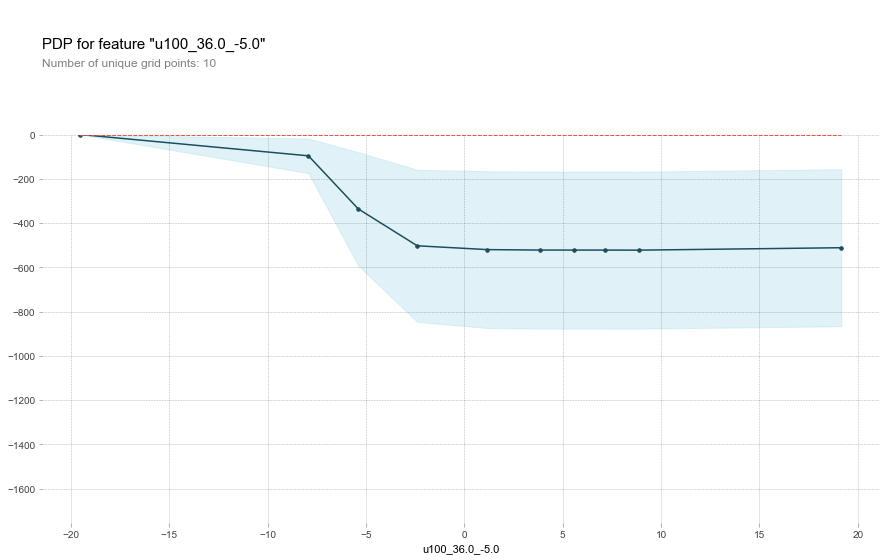

In [80]:
# 2nd most important variable according to permutation test
pdp_u100 = pdp.pdp_isolate(model=gb11, dataset=x_test, model_features=feature_names, feature='u100_36.0_-5.0')

pdp.pdp_plot(pdp_u100, 'u100_36.0_-5.0')
plt.show()

The PDP plot of interaction between the previous 2 variables shows exactly the conclusions we have had before. The energy production hits the peak when having the lowest u component on coordinate (36.0, -5.0) with the highest module on coordinate (36.0, -6) (yellow area), and it is the minimum when there are higher values of u component on (36.0, -5.0) and lower values of the variable module on (36.0, -6) (purple area). 

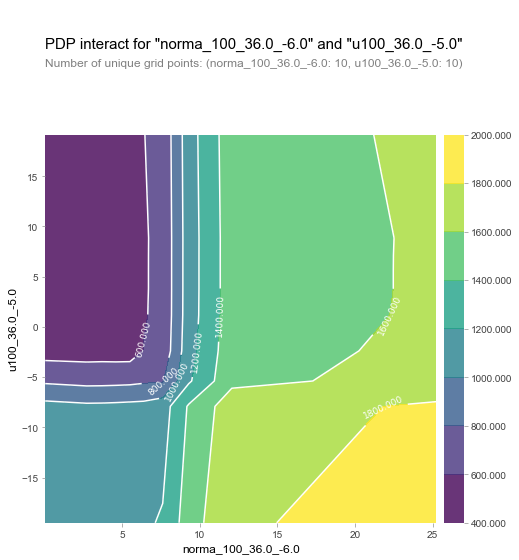

In [81]:
# Interaction between them 

pdp_inter = pdp.pdp_interact(model=gb11, dataset=x_test, model_features=feature_names, features=['norma_100_36.0_-6.0','u100_36.0_-5.0'])

pdp.pdp_interact_plot(pdp_interact_out = pdp_inter, feature_names = ['norma_100_36.0_-6.0','u100_36.0_-5.0'], plot_type = 'contour')
plt.show()

### SHAP values 

In [82]:
data_for_prediction = x_train.iloc[20]

In [83]:
data_for_prediction

norma_10_36.0_-5.0    6.218573
norma_10_36.0_-5.5    7.151807
norma_10_36.0_-6.0    8.601392
norma_10_36.0_-6.5    8.396501
norma_10_36.5_-5.0    4.872147
                        ...   
v100_36.5_-6.5       -0.766202
v100_37.0_-5.0        0.471494
v100_37.0_-5.5        0.142283
v100_37.0_-6.0       -0.806923
v100_37.0_-6.5       -1.399962
Name: 20, Length: 96, dtype: float64

In [84]:
data_for_prediction.values.reshape(1, -1).shape

(1, 96)

In [85]:
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

gb11.predict(data_for_prediction_array)

array([1569.58637684])

In [86]:
explainer = shap.TreeExplainer(gb11)
shap_values = explainer.shap_values(data_for_prediction)

In [87]:
shap_values

array([ 1.89328300e+00, -2.37802315e+00,  1.50503650e+01, -1.40288551e+01,
        4.22821995e+00,  4.20834336e+00,  6.59093787e+01, -1.84048966e+00,
       -4.95309236e+00, -3.69001543e-01, -4.08567173e+00, -7.88291485e-01,
       -5.61472551e+00,  3.04719951e+01,  5.82638554e+02, -2.94115384e+00,
       -2.97009504e+00,  8.27159762e-01, -1.62641988e+01, -7.87013225e-01,
        4.46276068e-02, -9.45183649e+00, -7.94149043e+00, -3.74135110e-01,
       -5.66274342e+00,  1.02490170e+01,  3.67571994e-01, -4.45448840e+00,
        8.31464075e-01, -6.39626114e+00, -2.26118551e+00, -2.14555829e+01,
       -2.54746914e+00, -9.15659700e+00,  5.37317013e-01,  6.04963411e-02,
        2.82758971e-01, -2.55645577e+01, -3.52237052e+00,  1.84727971e+00,
        1.92871643e-01,  6.69008661e+00,  2.39582301e+00, -3.91867017e+00,
        5.27139068e+00, -2.87385201e-01, -6.98542347e+00, -4.16382224e+00,
       -5.42216100e+00, -1.33693039e+00, -1.47518995e+00,  4.37564328e+00,
       -7.04887788e+00,  

In [88]:
explainer.expected_value

array([1006.97805157])

It is obvious to observe in pink part that, the variable that has most impact on the prediction is precisely the most important variable on permutation test done before, and this module on coordinate (36.0, -6) increases the prediction.

In [89]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Advanced Uses of SHAP values

#### Summary Plots

In [90]:
shap_values

array([ 1.89328300e+00, -2.37802315e+00,  1.50503650e+01, -1.40288551e+01,
        4.22821995e+00,  4.20834336e+00,  6.59093787e+01, -1.84048966e+00,
       -4.95309236e+00, -3.69001543e-01, -4.08567173e+00, -7.88291485e-01,
       -5.61472551e+00,  3.04719951e+01,  5.82638554e+02, -2.94115384e+00,
       -2.97009504e+00,  8.27159762e-01, -1.62641988e+01, -7.87013225e-01,
        4.46276068e-02, -9.45183649e+00, -7.94149043e+00, -3.74135110e-01,
       -5.66274342e+00,  1.02490170e+01,  3.67571994e-01, -4.45448840e+00,
        8.31464075e-01, -6.39626114e+00, -2.26118551e+00, -2.14555829e+01,
       -2.54746914e+00, -9.15659700e+00,  5.37317013e-01,  6.04963411e-02,
        2.82758971e-01, -2.55645577e+01, -3.52237052e+00,  1.84727971e+00,
        1.92871643e-01,  6.69008661e+00,  2.39582301e+00, -3.91867017e+00,
        5.27139068e+00, -2.87385201e-01, -6.98542347e+00, -4.16382224e+00,
       -5.42216100e+00, -1.33693039e+00, -1.47518995e+00,  4.37564328e+00,
       -7.04887788e+00,  

This plot makes a summary of permutation importance and partial dependence plot. It is very clear to see that, when higher value of module on (36.0, -6) (according to the line on the right, the color of the points is warmer), higher the energy production; as for u component on (36.0, -5.0), when lower value of it, the energy production becomes higher (points with colder color tend to have higher SHAP value). 

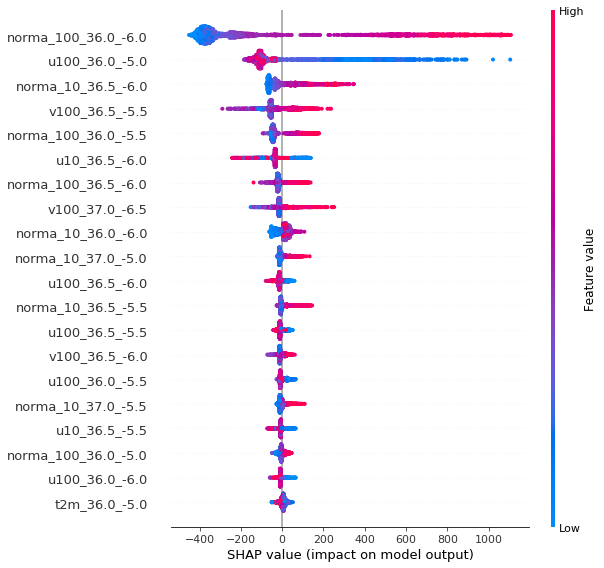

In [91]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(x_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, x_test)

#### SHAP Dependence Contribution Plots

From this plot, we can see that in general, having higher module in coordinates (36, -6) increases the energy production. The critical values for the variable is around 10, if the module is smaller than 10, having higher u100 component in (36, -6) will decrease the the production while if it’s higher than 10, higher u100 component in (36, -6) will increase the energy production.

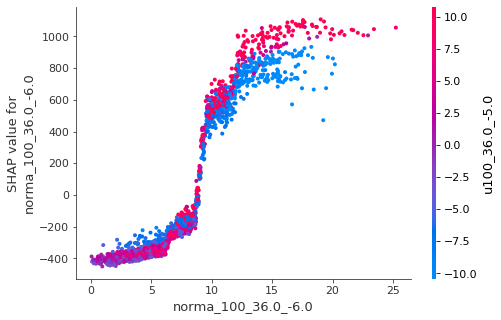

In [92]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x_test)

# make plot.
shap.dependence_plot('norma_100_36.0_-6.0', shap_values, x_test, interaction_index="u100_36.0_-5.0")